In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv('bank-additional-full.csv', sep =";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df.shape

(41188, 21)

In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [ ]:
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [ ]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [ ]:
#histogram
def histogram(x):
  n = len(x.columns)

  col = 3
  row = n//col + 1

  plt.figure(figsize = (15, 25))
  for i in range(n):
    plt.subplot(row, col, i+1)
    sns.histplot( x = x[x.columns[i]], bins=30, color='blue', edgecolor='black', kde=True)
    plt.xlabel(x.columns[i])
    plt.ylabel('Frequency')
  plt.show()

In [ ]:
#confusion matrix
def confusionMatrix(actual, prediction):
  conf_matrix = confusion_matrix(actual, prediction)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def best_threshold(y_true, y_scores):
  roc_auc = roc_auc_score(y_true, y_scores)
  precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
  f1_scores = 2 * recall * precision / (recall + precision)
  threshold = thresholds[np.argmax(f1_scores)]
  return threshold

In [ ]:
def plot_roc_curve(y_true, y_prob):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plot_pr_curve(y_true, y_prob):

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)

    # Plot PR curve
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

In [ ]:
def boxplot(x):
  plt.figure(figsize = (15, 20))
  n = len(x.columns)
  cols = 3
  rows = n//cols + 1
  for i in range(n):
    plt.subplot(rows, cols, i+1)
    sns.boxplot( data = x[x.columns[i]])
  plt.show()

In [ ]:
def label(encoder, col, df):
  for i in col:
    df[i] = encoder.fit_transform(df[i])
  return df

In [ ]:
def remove_outliers_IQR(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

In [ ]:
#transform distributions
def quantile_transform(x, columns, max_samples = 10000):
  n_samples = min(len(x), max_samples)
  qt = QuantileTransformer(n_quantiles=n_samples, output_distribution='normal', random_state=0)
  for col in columns:
    x[col] = qt.fit_transform(x[[col]])

  return x

In [ ]:
def xgboost(X_train, y_train, X_test, y_test):
  dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
  bst = xgb.train({}, dtrain, num_boost_round=10)
  dtest = xgb.DMatrix(X_test, enable_categorical=True)

  y_train_prob = bst.predict(dtrain)
  y_test_prob = bst.predict(dtest)

  threshold = best_threshold(y_train, y_train_prob)

  y_pred_train = (y_train_prob >= threshold).astype(int)
  y_pred_test = (y_test_prob >= threshold).astype(int)

  return y_pred_train, y_pred_test, y_test_prob

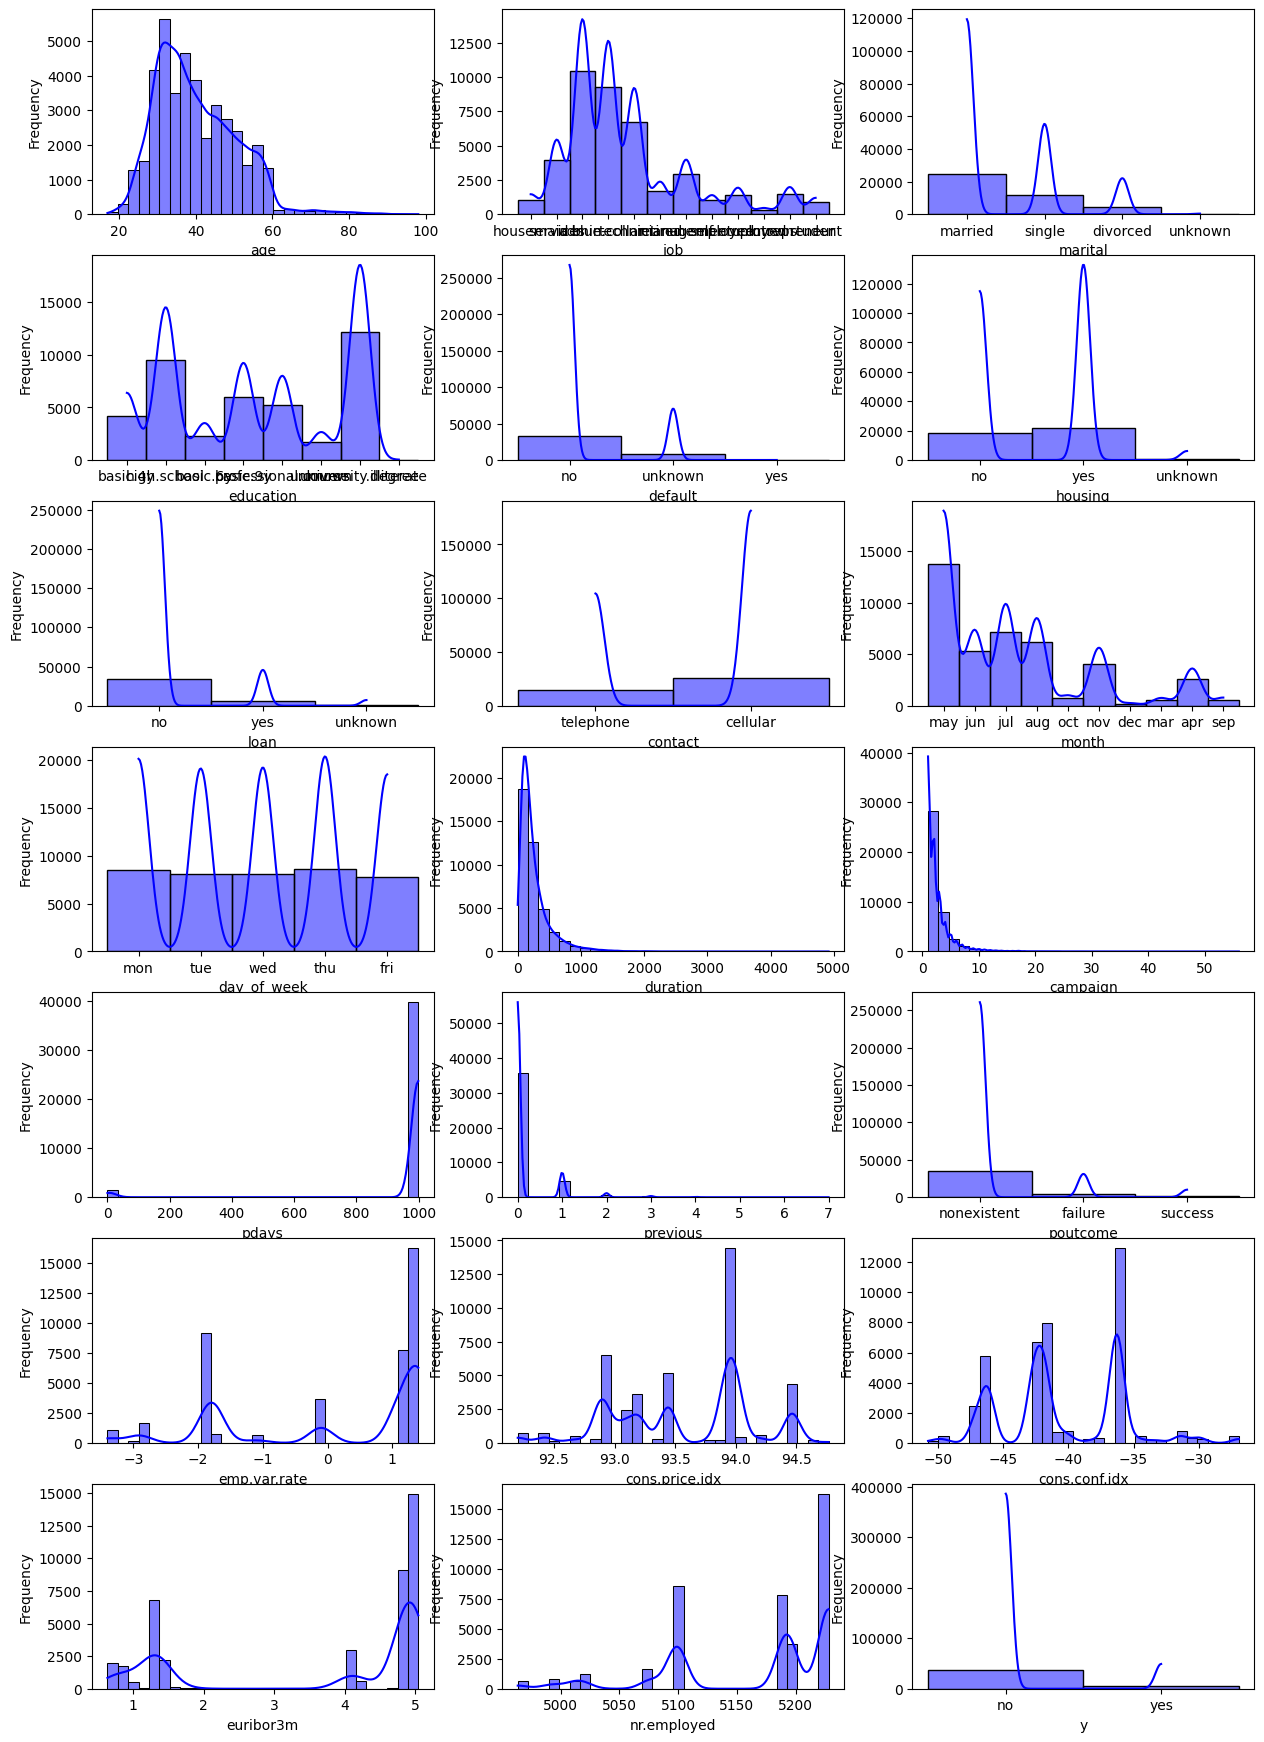

In [ ]:
histogram(df)

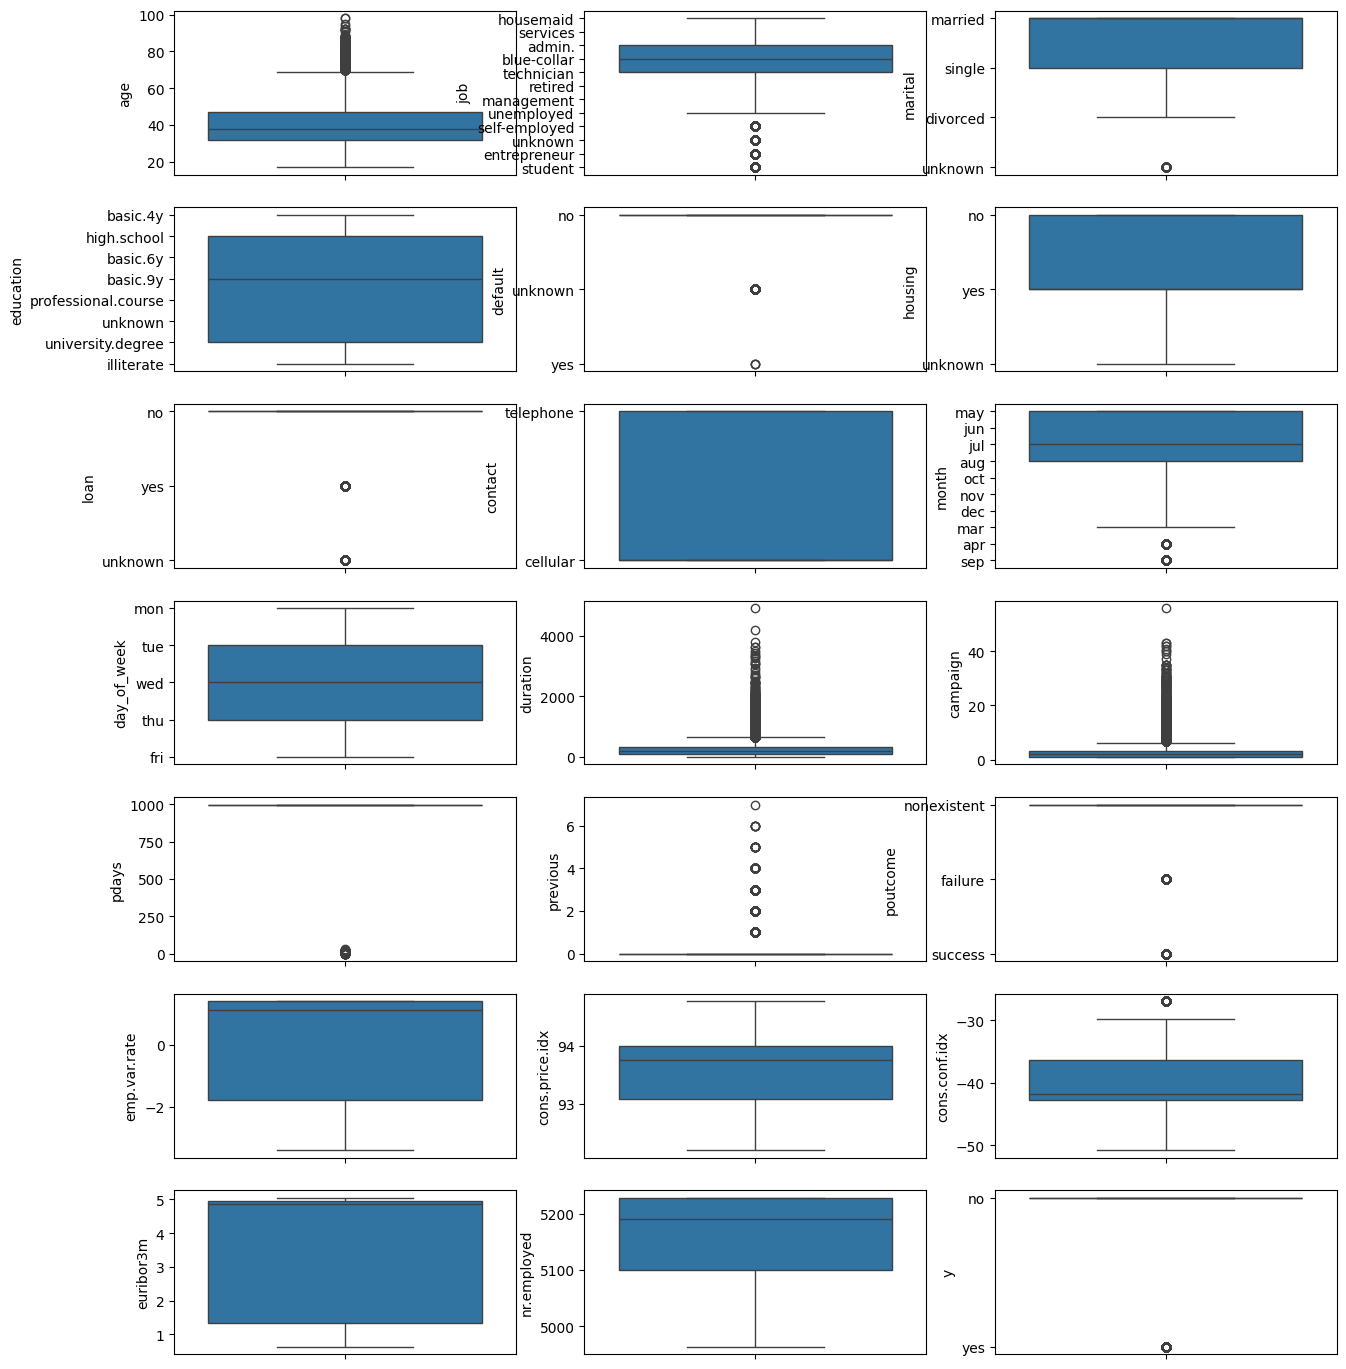

In [ ]:
boxplot(df)

In [ ]:
features = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome', 'y']
df  = label(labelEncoder, features, df)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [ ]:
df.shape

(41188, 21)

In [ ]:
columns = df.drop(columns = features).columns
columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
df_outliers = remove_outliers_IQR(df, columns)
df_outliers.shape

(49813, 21)

In [ ]:
X, y = df_outliers.drop(columns=['y']), df_outliers[['y']]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42,stratify=y)

In [ ]:
X_train = quantile_transform(X_train, X.columns)
X_test = quantile_transform(X_test, X.columns)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('scaler', StandardScaler())]),
                X.columns.tolist()
            )
        ]
    )),
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Train model
pipeline.fit(X_train, y_train)

y_train_prob = pipeline.predict_proba(X_train)[:,1]
y_test_prob = pipeline.predict_proba(X_test)[:,1]

threshold = best_threshold(y_train, y_train_prob)

y_pred_train = (y_train_prob >= threshold).astype(int)
y_pred_test = (y_test_prob >= threshold).astype(int)

# Evaluate model
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)}")

Train Accuracy: 0.9708155583437892
Test Accuracy: 0.9434909163906454


In [ ]:
threshold

0.6155652

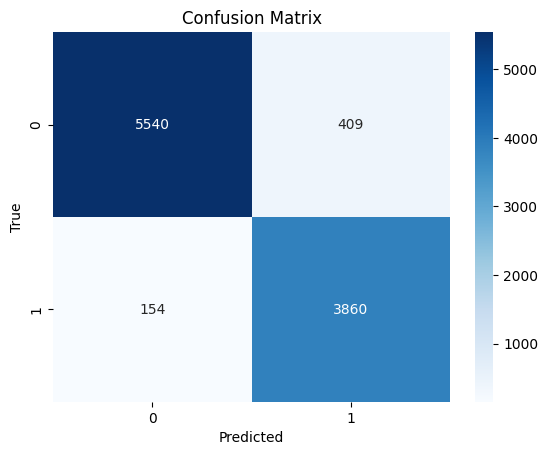

In [ ]:
confusionMatrix(y_test, y_pred_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5949
           1       0.90      0.96      0.93      4014

    accuracy                           0.94      9963
   macro avg       0.94      0.95      0.94      9963
weighted avg       0.95      0.94      0.94      9963



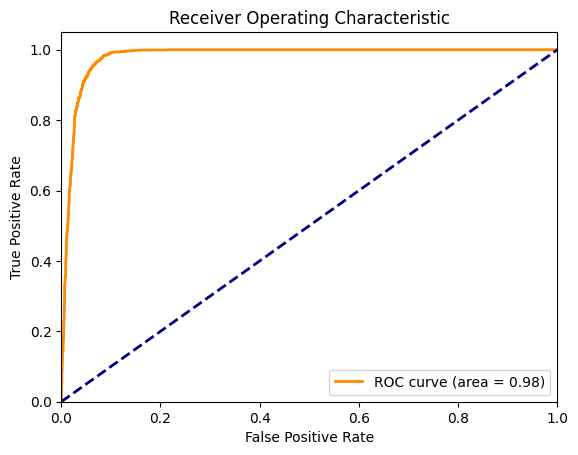

In [ ]:
plot_roc_curve(y_test, y_test_prob)

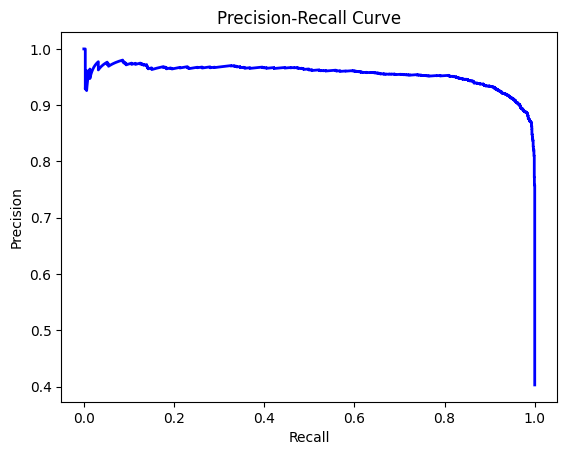

In [ ]:
plot_pr_curve(y_test, y_test_prob)